In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col


In [4]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
import matplotlib.style as style
style.use('fivethirtyeight')

In [5]:
spark = SparkSession.builder.appName('DIABETES').getOrCreate()

In [6]:
from google.colab import files
files.upload()

Saving diabetes.csv to diabetes.csv


{'diabetes.csv': b'Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome\r\n6,148,72,35,0,33.6,0.627,50,1\r\n1,85,66,29,0,26.6,0.351,31,0\r\n8,183,64,0,0,23.3,0.672,32,1\r\n1,89,66,23,94,28.1,0.167,21,0\r\n0,137,40,35,168,43.1,2.288,33,1\r\n5,116,74,0,0,25.6,0.201,30,0\r\n3,78,50,32,88,31,0.248,26,1\r\n10,115,0,0,0,35.3,0.134,29,0\r\n2,197,70,45,543,30.5,0.158,53,1\r\n8,125,96,0,0,0,0.232,54,1\r\n4,110,92,0,0,37.6,0.191,30,0\r\n10,168,74,0,0,38,0.537,34,1\r\n10,139,80,0,0,27.1,1.441,57,0\r\n1,189,60,23,846,30.1,0.398,59,1\r\n5,166,72,19,175,25.8,0.587,51,1\r\n7,100,0,0,0,30,0.484,32,1\r\n0,118,84,47,230,45.8,0.551,31,1\r\n7,107,74,0,0,29.6,0.254,31,1\r\n1,103,30,38,83,43.3,0.183,33,0\r\n1,115,70,30,96,34.6,0.529,32,1\r\n3,126,88,41,235,39.3,0.704,27,0\r\n8,99,84,0,0,35.4,0.388,50,0\r\n7,196,90,0,0,39.8,0.451,41,1\r\n9,119,80,35,0,29,0.263,29,1\r\n11,143,94,33,146,36.6,0.254,51,1\r\n10,125,70,26,115,31.1,0.205,41,1\r\n7,147,76,0,0,39.4,0.257,43

In [7]:
df = spark.read.csv('diabetes.csv', inferSchema=True, header=True)
df.show(truncate=False)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI |DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|6          |148    |72           |35           |0      |33.6|0.627                   |50 |1      |
|1          |85     |66           |29           |0      |26.6|0.351                   |31 |0      |
|8          |183    |64           |0            |0      |23.3|0.672                   |32 |1      |
|1          |89     |66           |23           |94     |28.1|0.167                   |21 |0      |
|0          |137    |40           |35           |168    |43.1|2.288                   |33 |1      |
|5          |116    |74           |0            |0      |25.6|0.201                   |30 |0      |
|3          |78     |50           |32           |88     |31.0|0.248                   |26 |1      |


In [8]:
## print schema
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [9]:
## summary statistics
df.summary().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

In [10]:
from pyspark.sql.functions import *

col_null_cnt_df =  df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns])

display(col_null_cnt_df)

DataFrame[Pregnancies: bigint, Glucose: bigint, BloodPressure: bigint, SkinThickness: bigint, Insulin: bigint, BMI: bigint, DiabetesPedigreeFunction: bigint, Age: bigint, Outcome: bigint]

In [11]:
## checking missing data
from pyspark.sql.functions import count, when, col
df.select(
    [
        count(when(col(column_name).isNull(), column_name)).alias(column_name)
        for column_name in df.columns
    ]
).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [12]:
df.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [13]:
## Count the Outcome value
outcome_distribution = df.groupBy("Outcome").count()
outcome_distribution.show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



In [14]:
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


## Histogram of outcome


In [15]:
## Get target

a = 'Outcome'
## Get quantitative features and delete the unnecessary features
quantitative = [f[0] for f in df.dtypes if f[1] != 'string']
quantitative.remove('Outcome')

# Get categorical features
b = [f[0] for f in df.dtypes if f[1] == 'string']

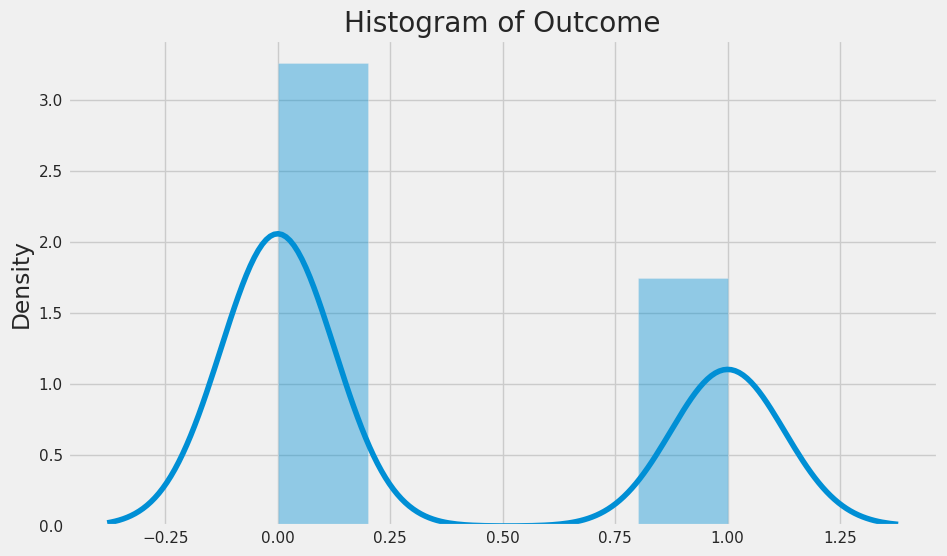

In [16]:
plt.figure(figsize=(10, 6))
sns.distplot(df.select(a).rdd.flatMap(lambda x: x).collect())
plt.title('Histogram of %s' % a)
plt.show()


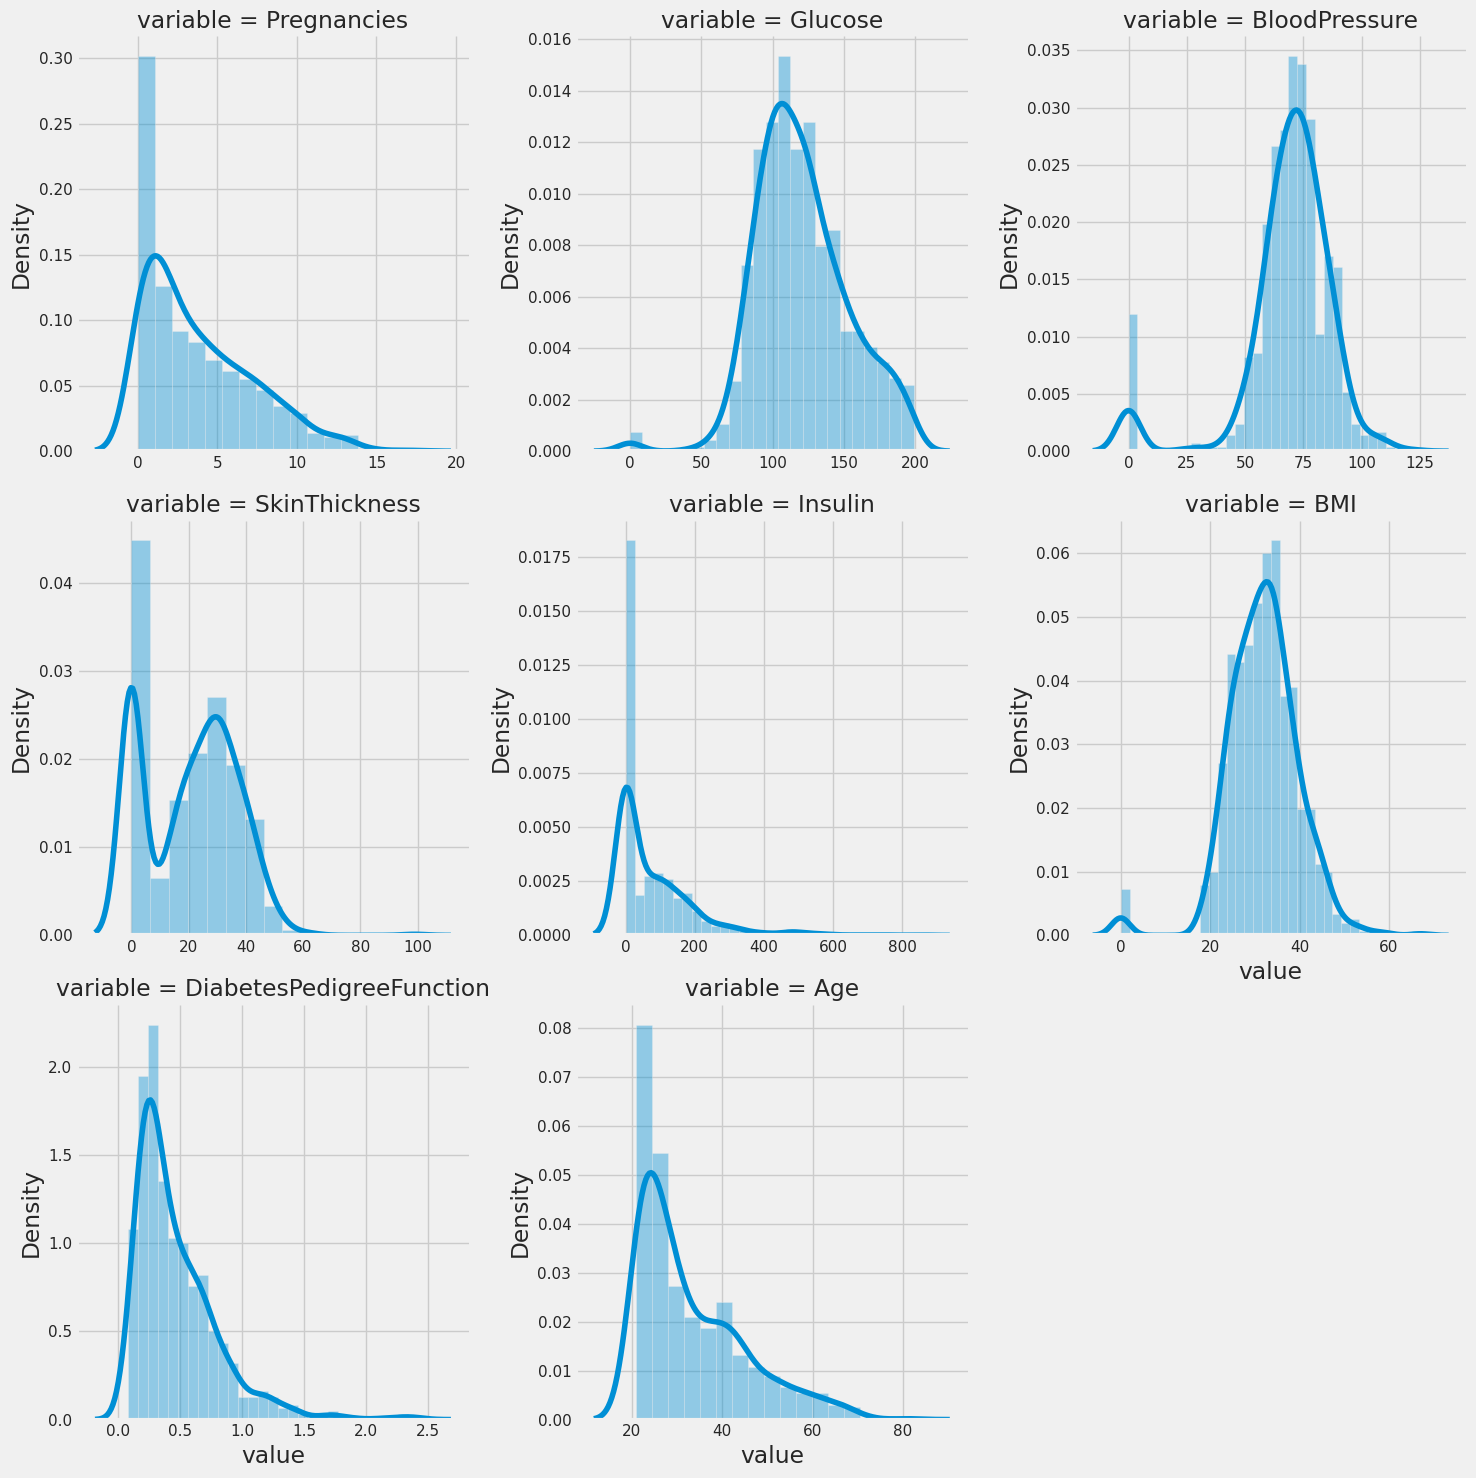

In [17]:
## Convert pyspark df to pandas df
df1 = df.toPandas()

## Use the melt function on the Pandas DataFrame
f = pd.melt(df1, value_vars=quantitative)

## Create a FacetGrid
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, height=5)
g = g.map(sns.distplot, "value")

## Plot
plt.show()

## PairPlot

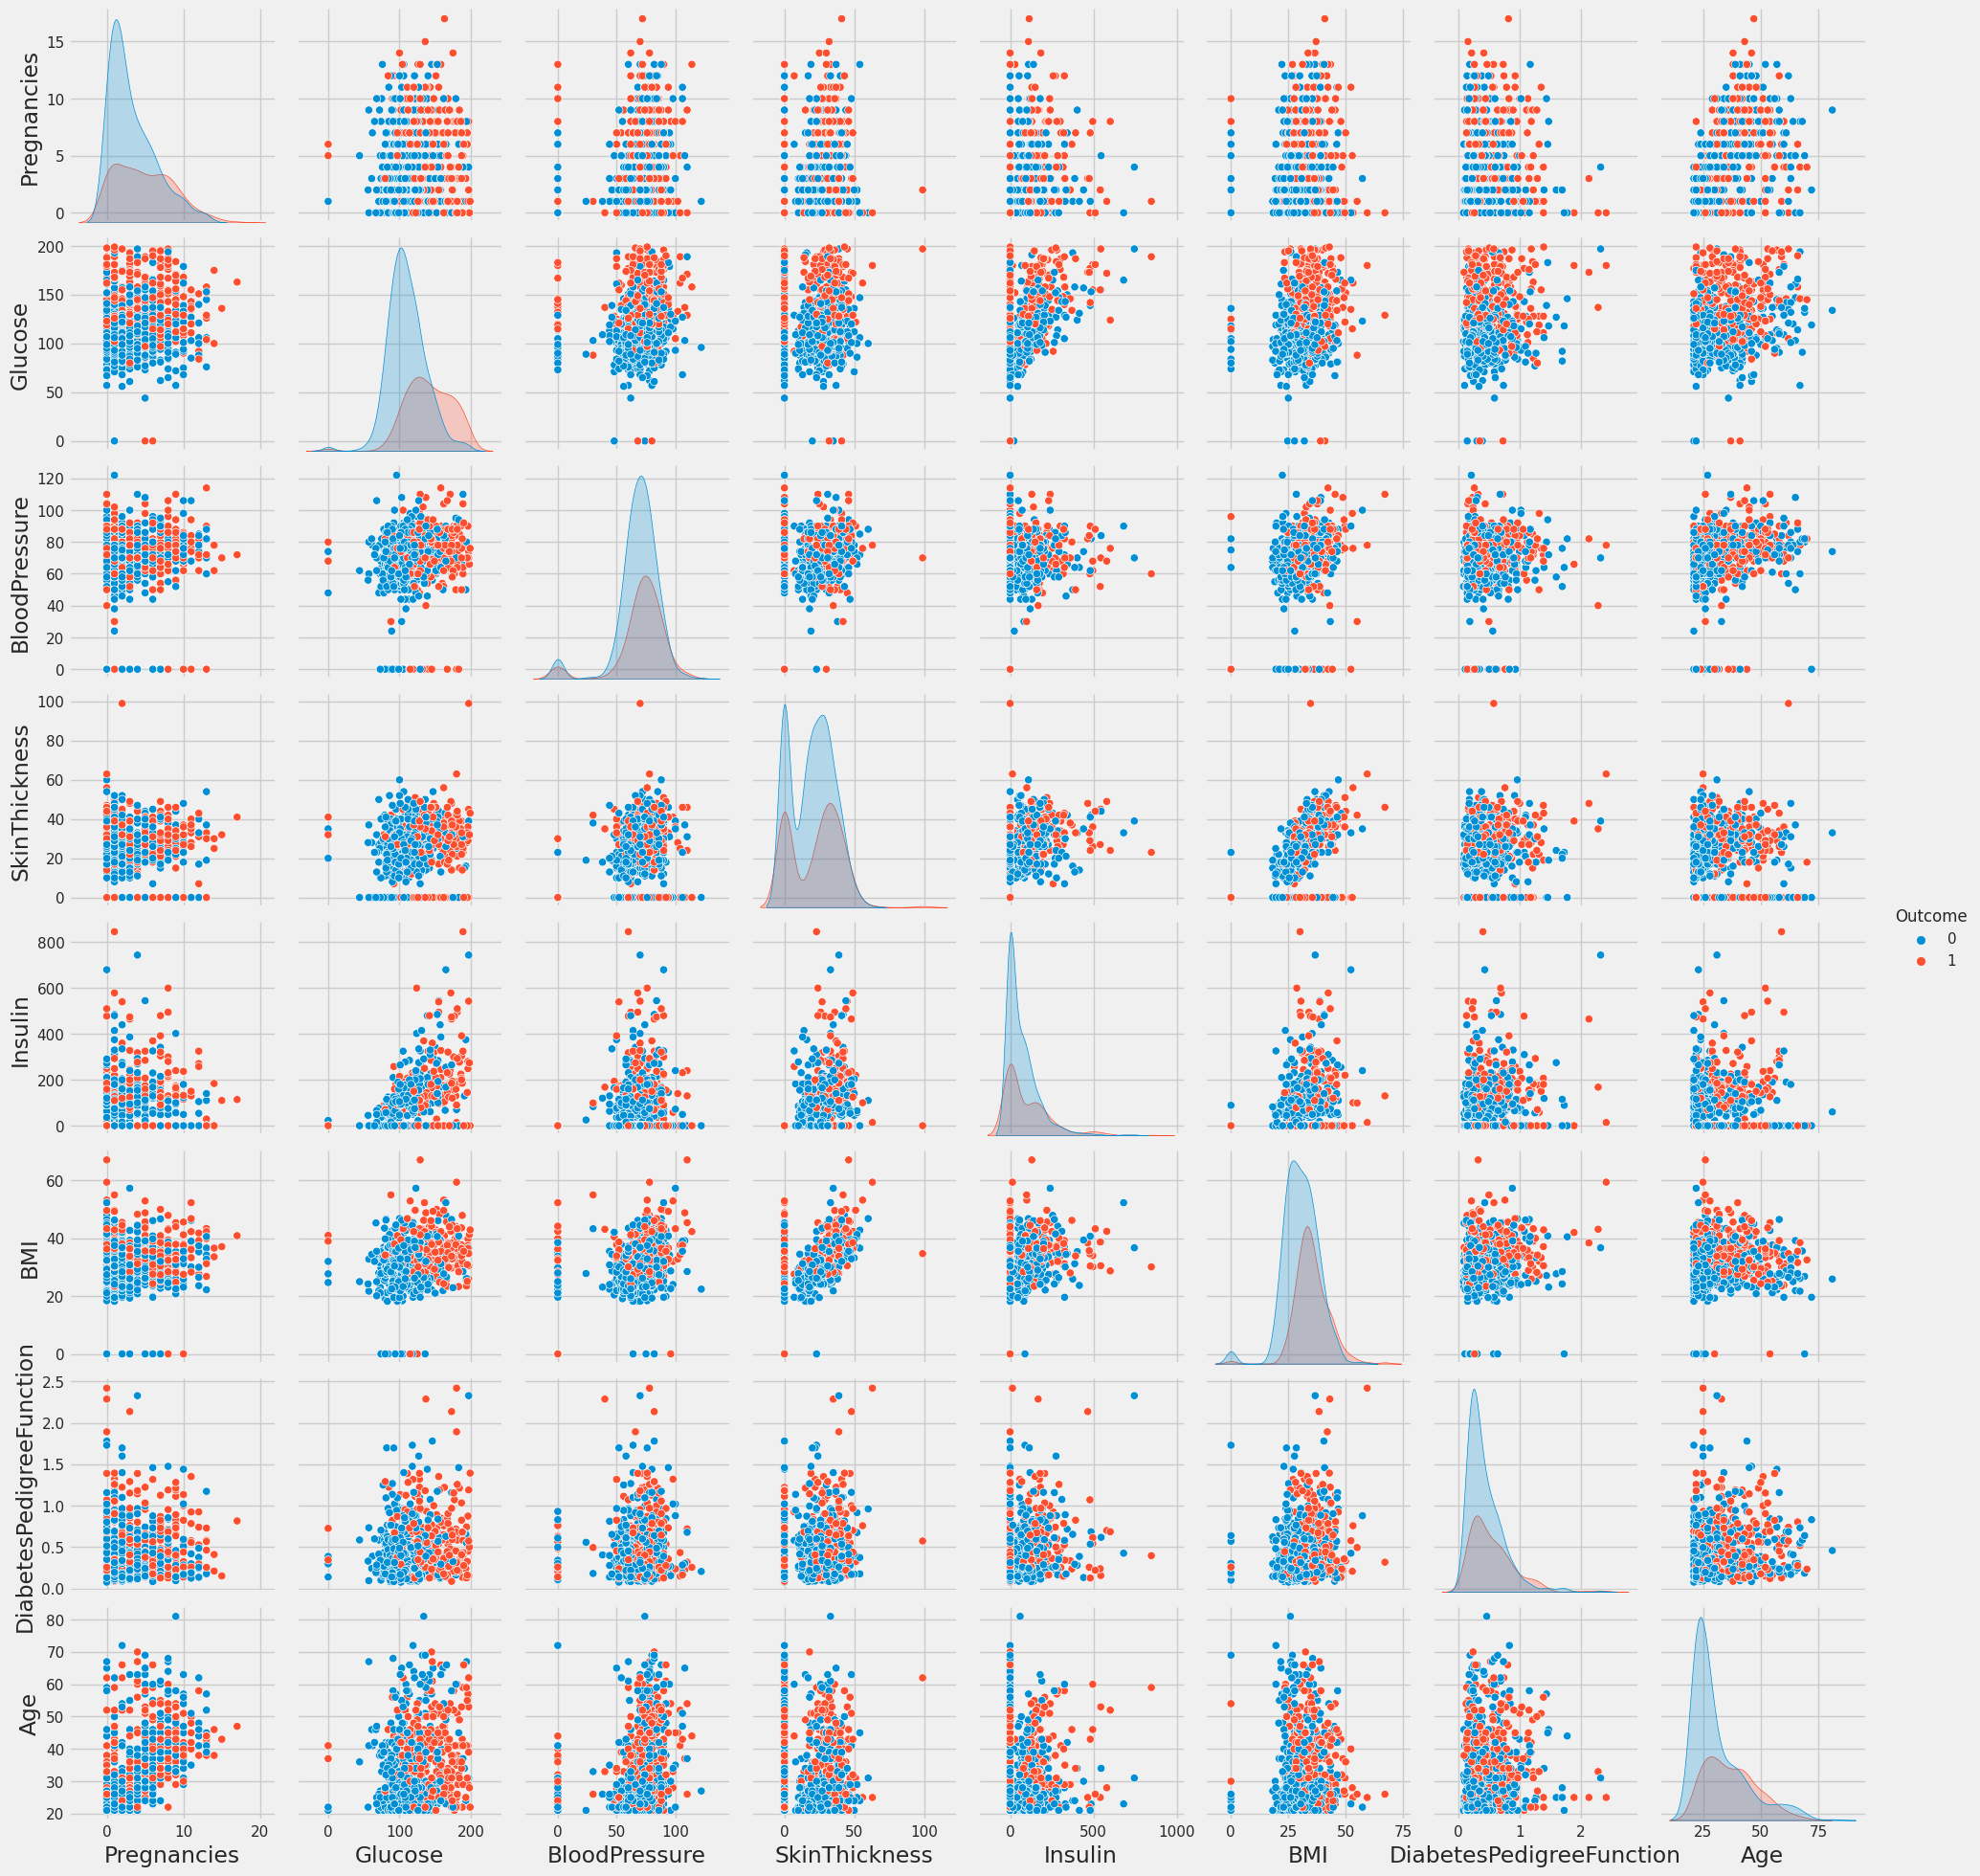

In [18]:

sns.pairplot(df1, hue='Outcome')
plt.show()

## Histograms

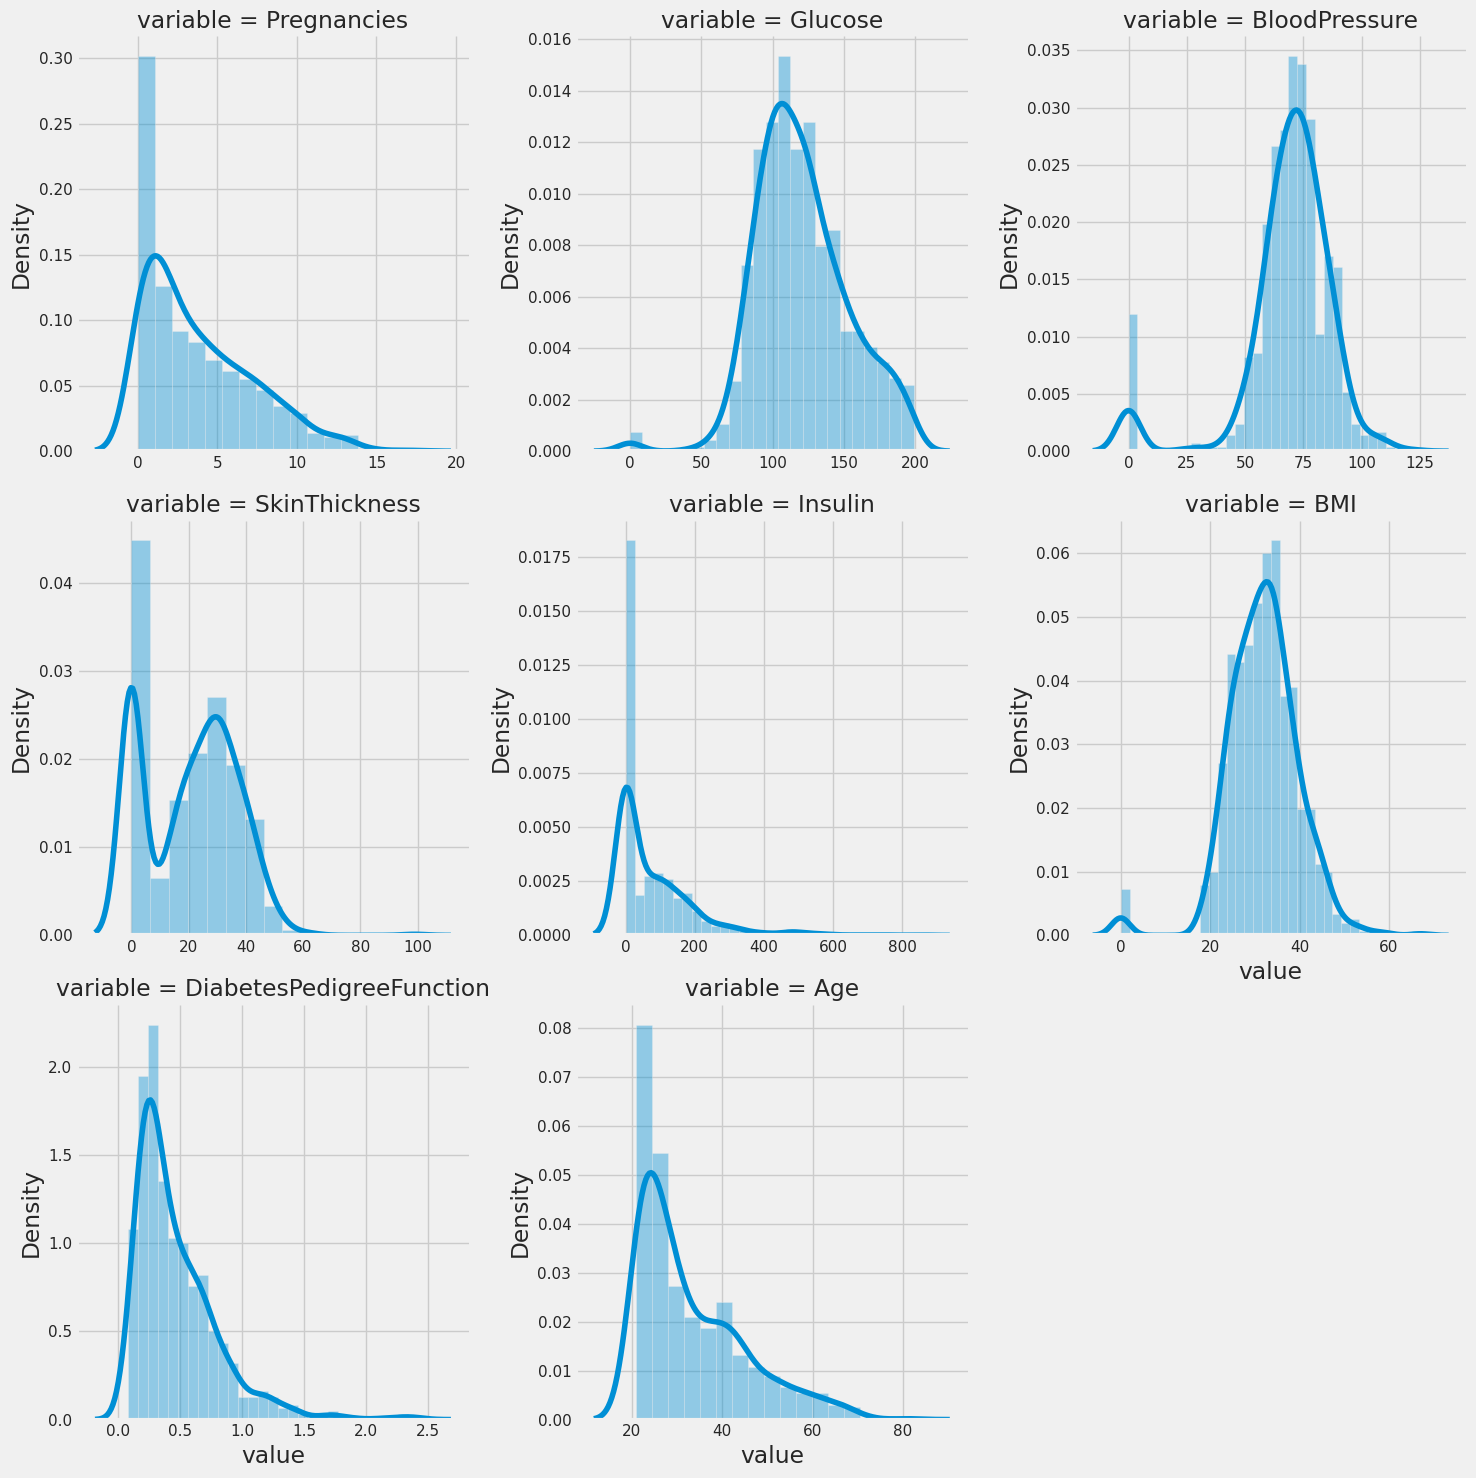

In [19]:
## Use the melt function on the Pandas DataFrame
f = pd.melt(df1, value_vars=quantitative)

## Create a FacetGrid
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, height=5)
g = g.map(sns.distplot, "value")

## Plot
plt.show()

## Countplot

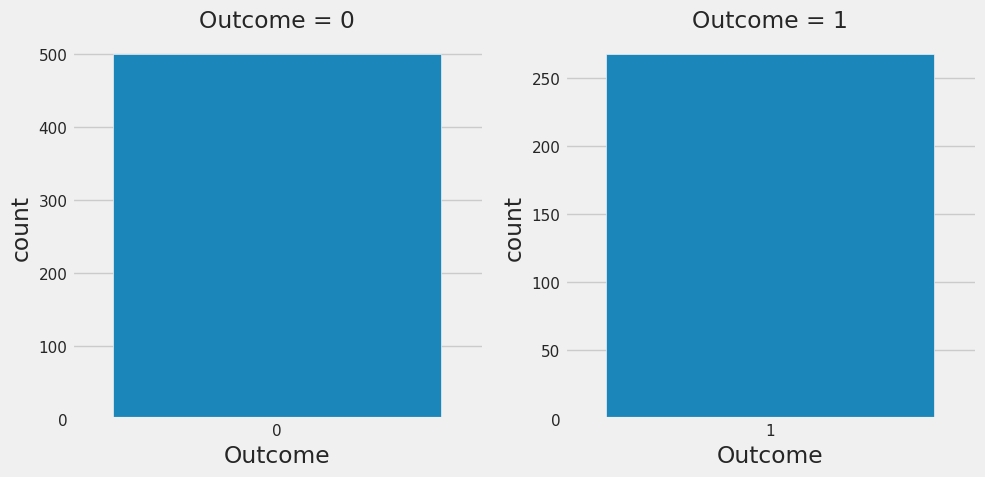

In [20]:
def countplot(x, **kwargs):
    sns.countplot(x=x)
g = sns.FacetGrid(df1, col='Outcome', col_wrap=3, sharex=False, sharey=False, height=5)
g = g.map(countplot, 'Outcome')

##
plt.show()

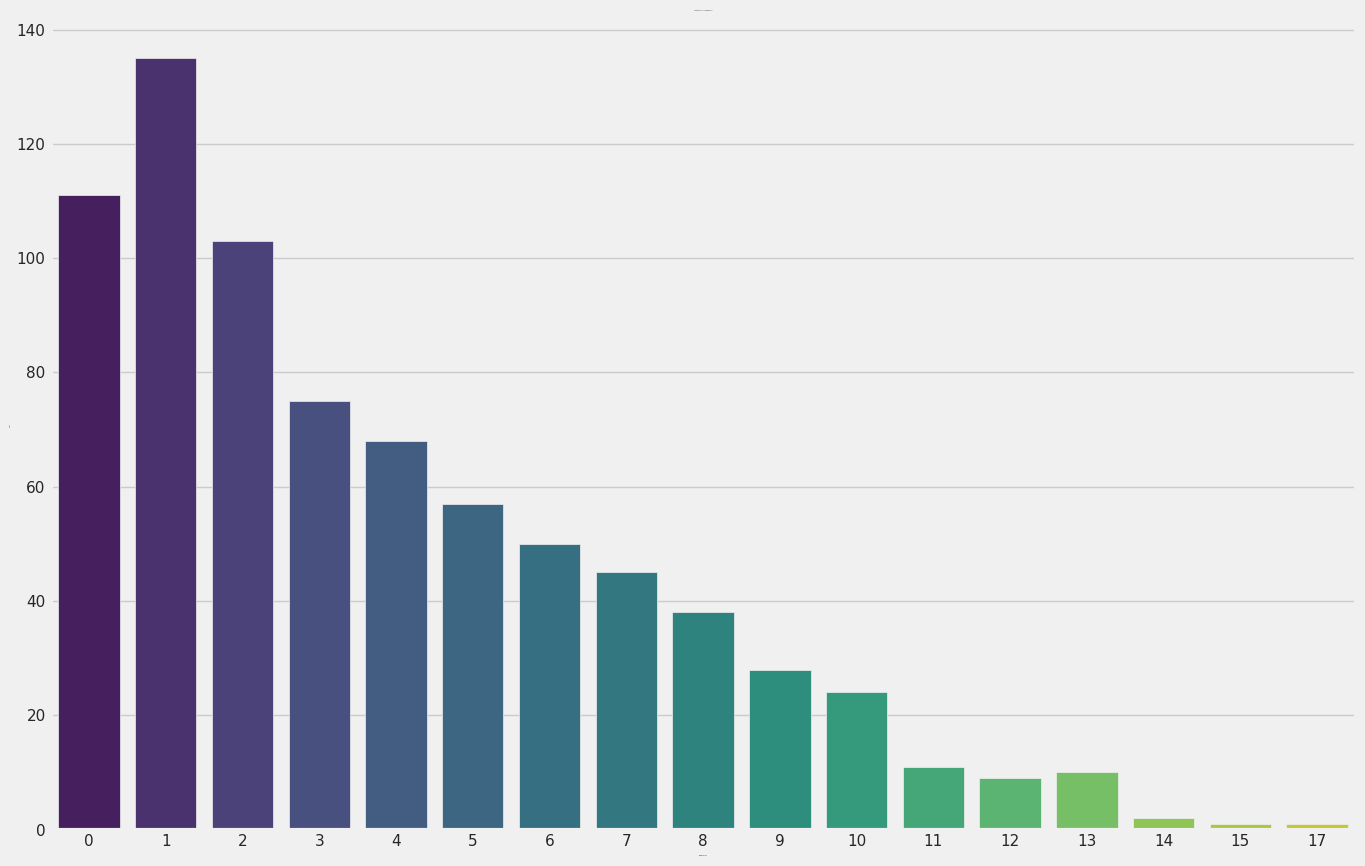

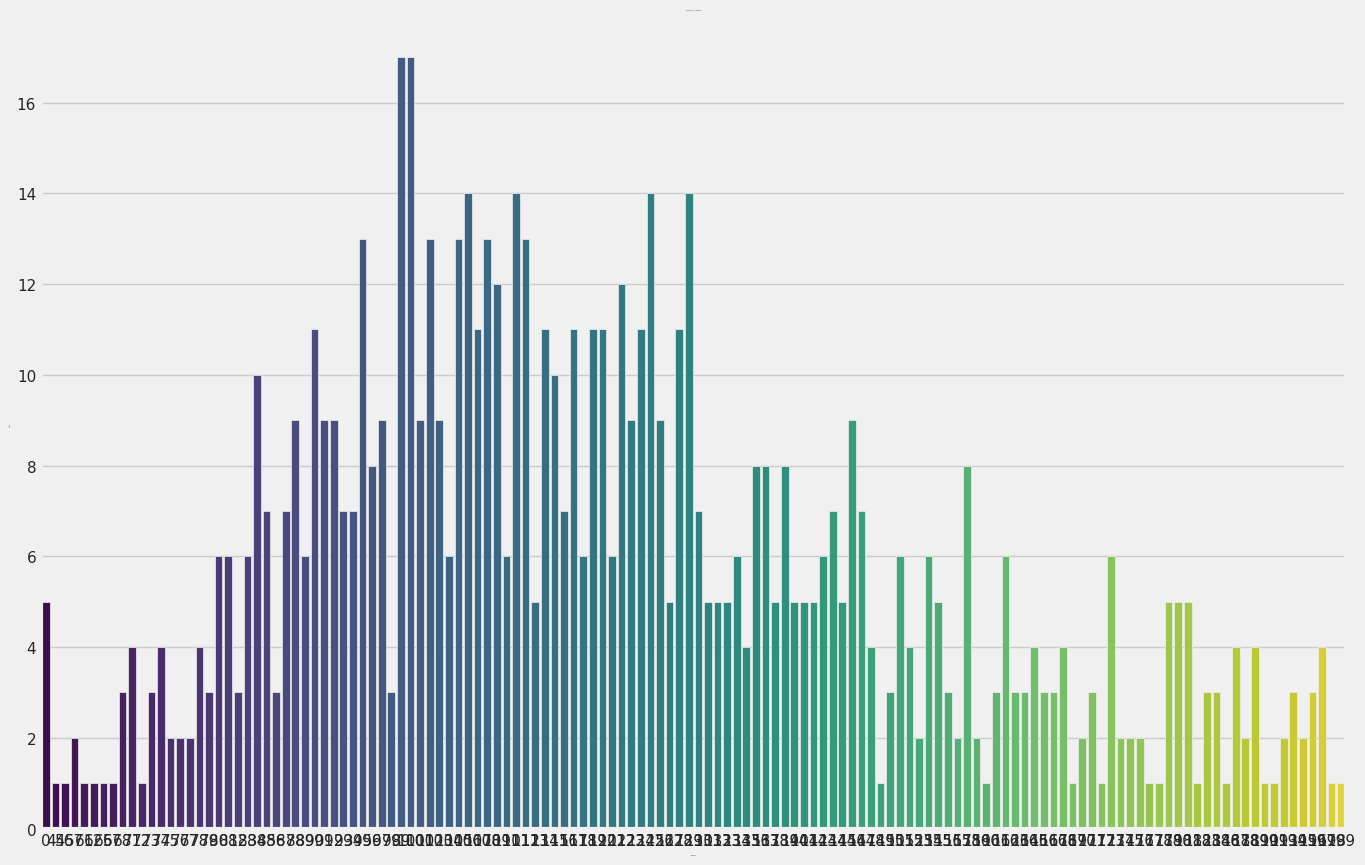

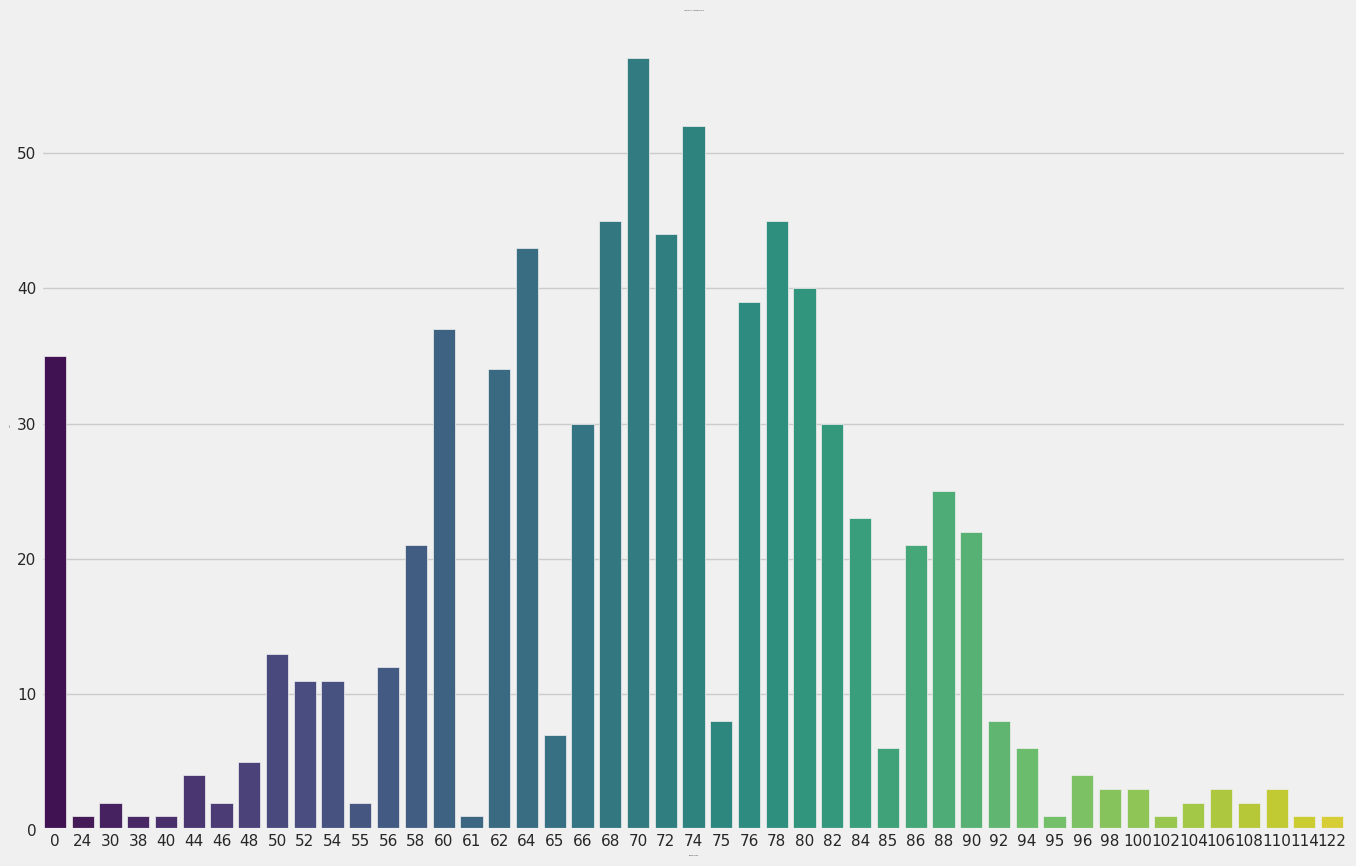

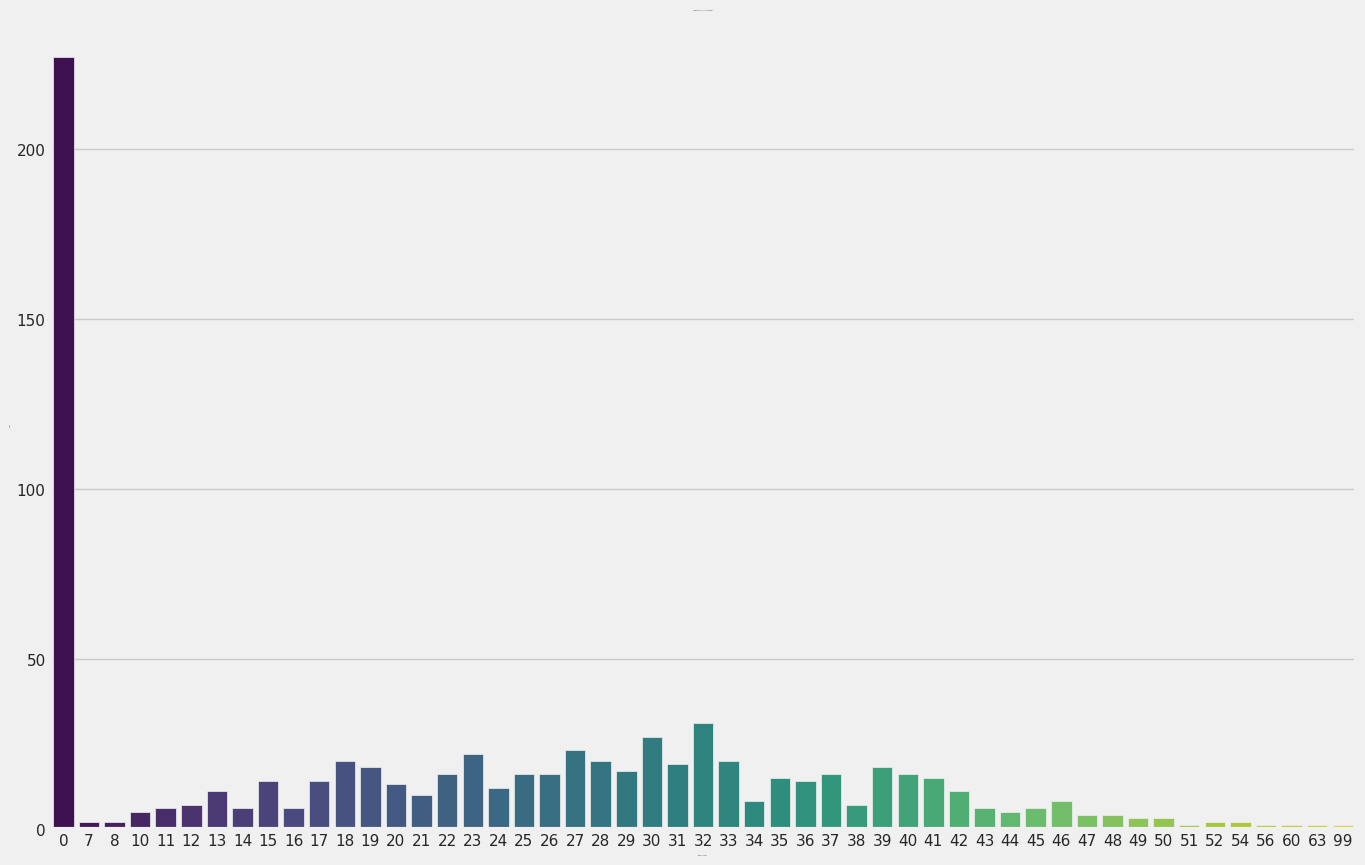

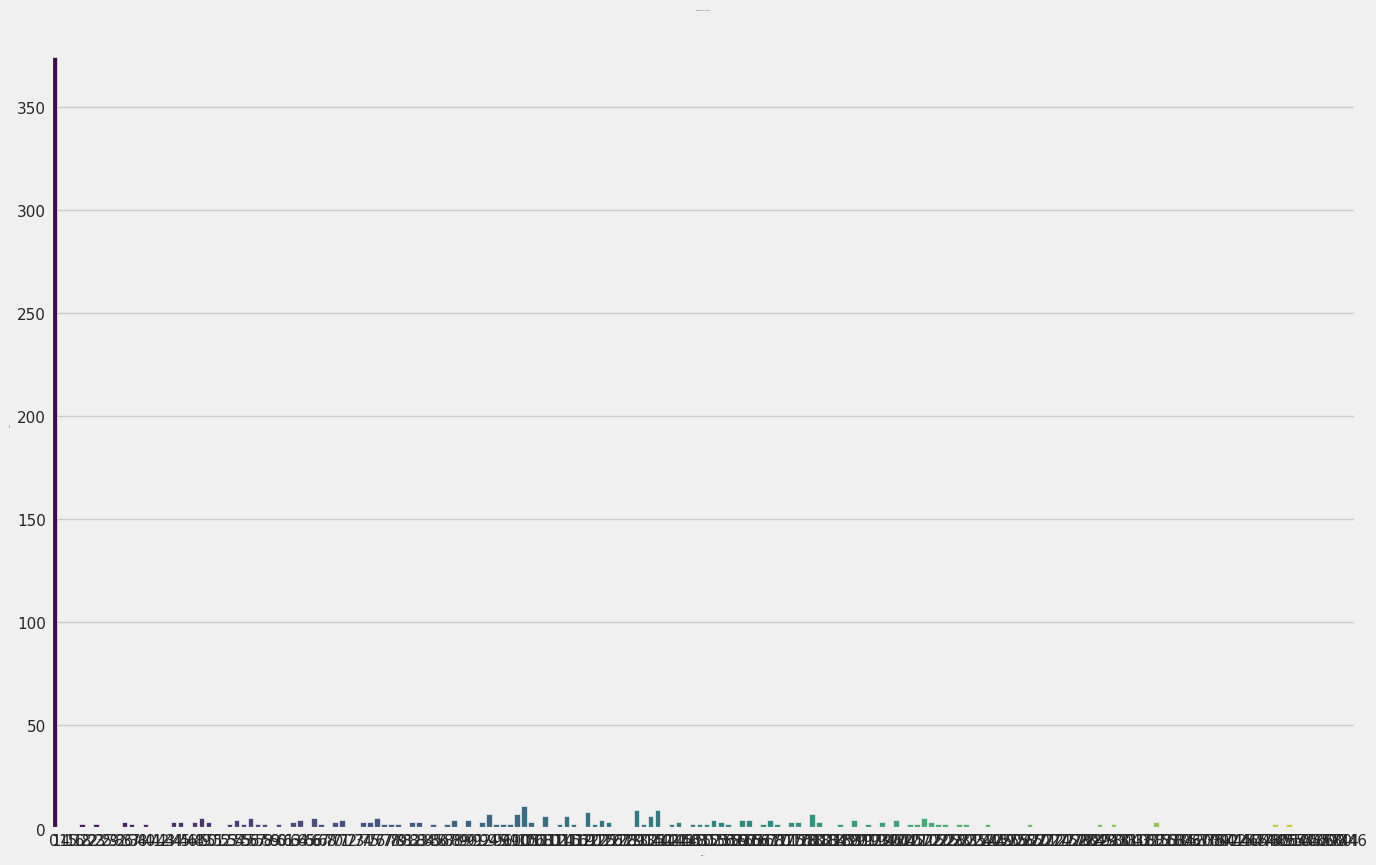

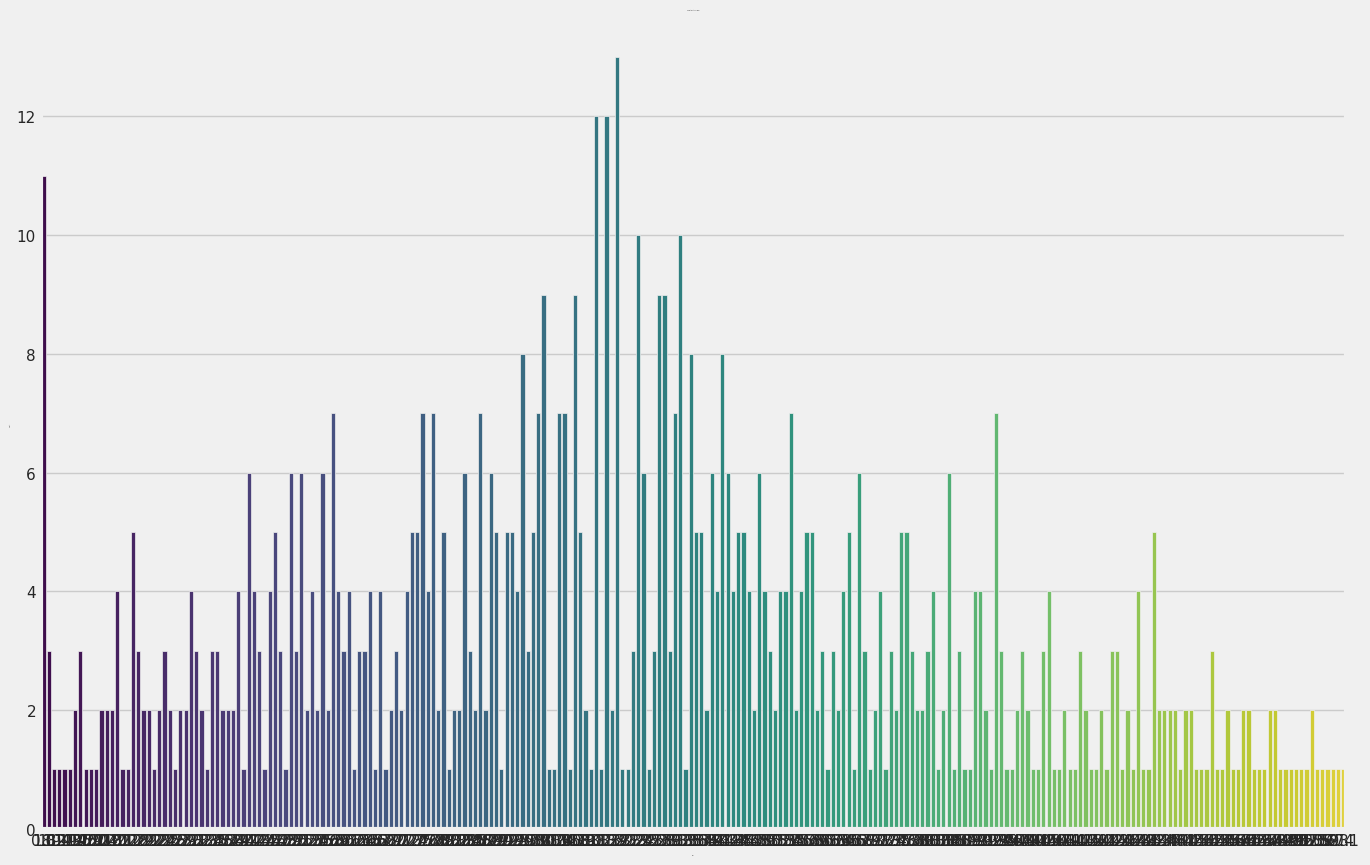

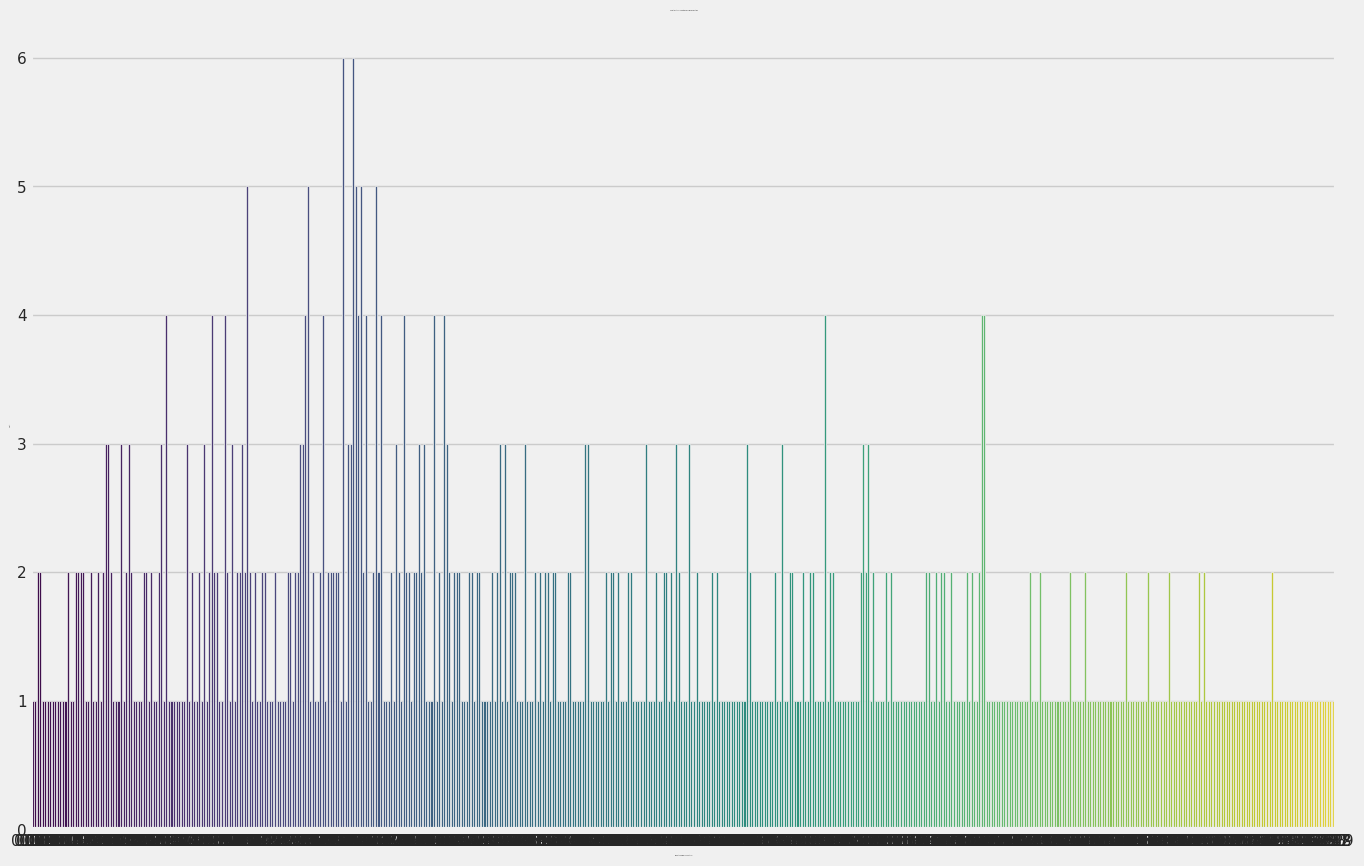

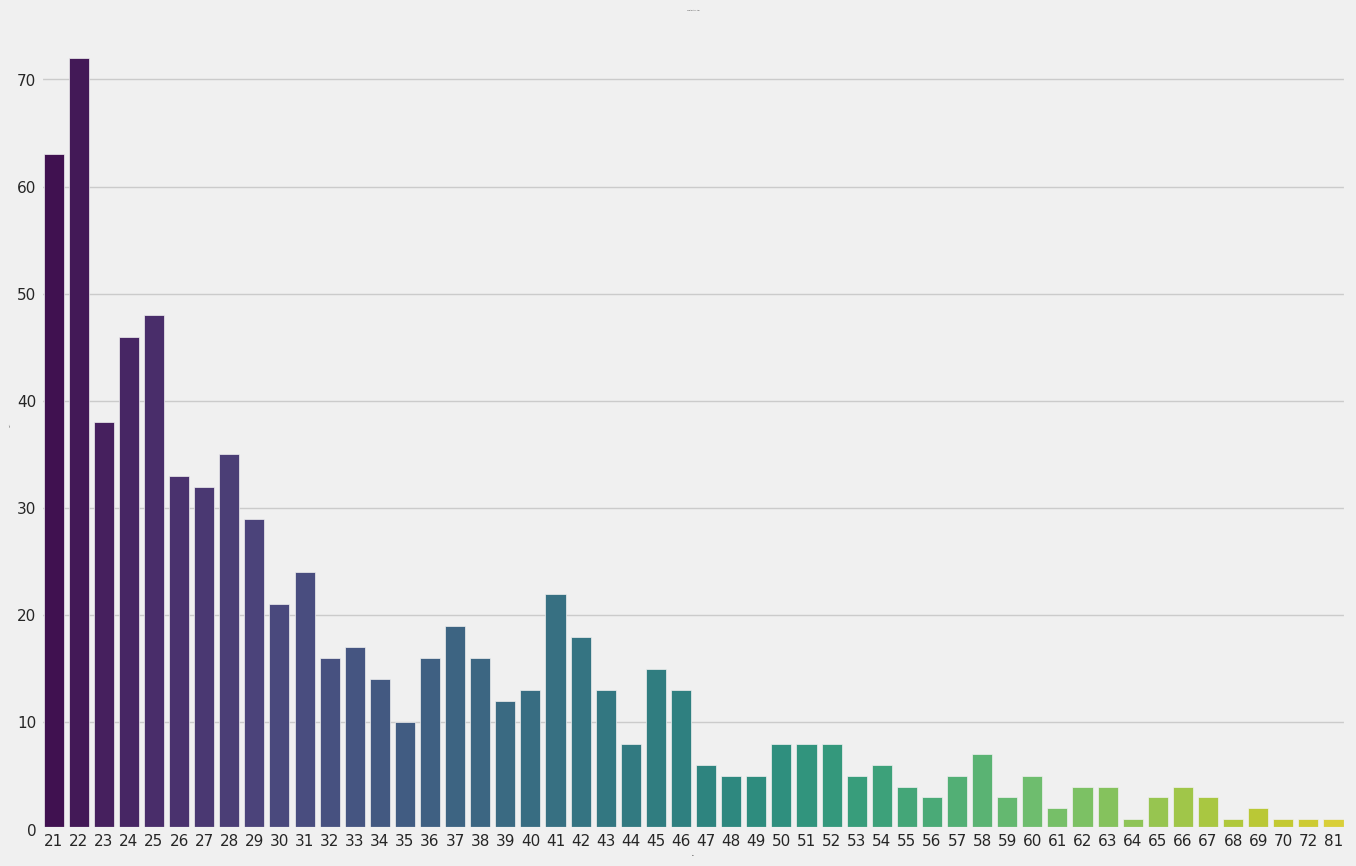

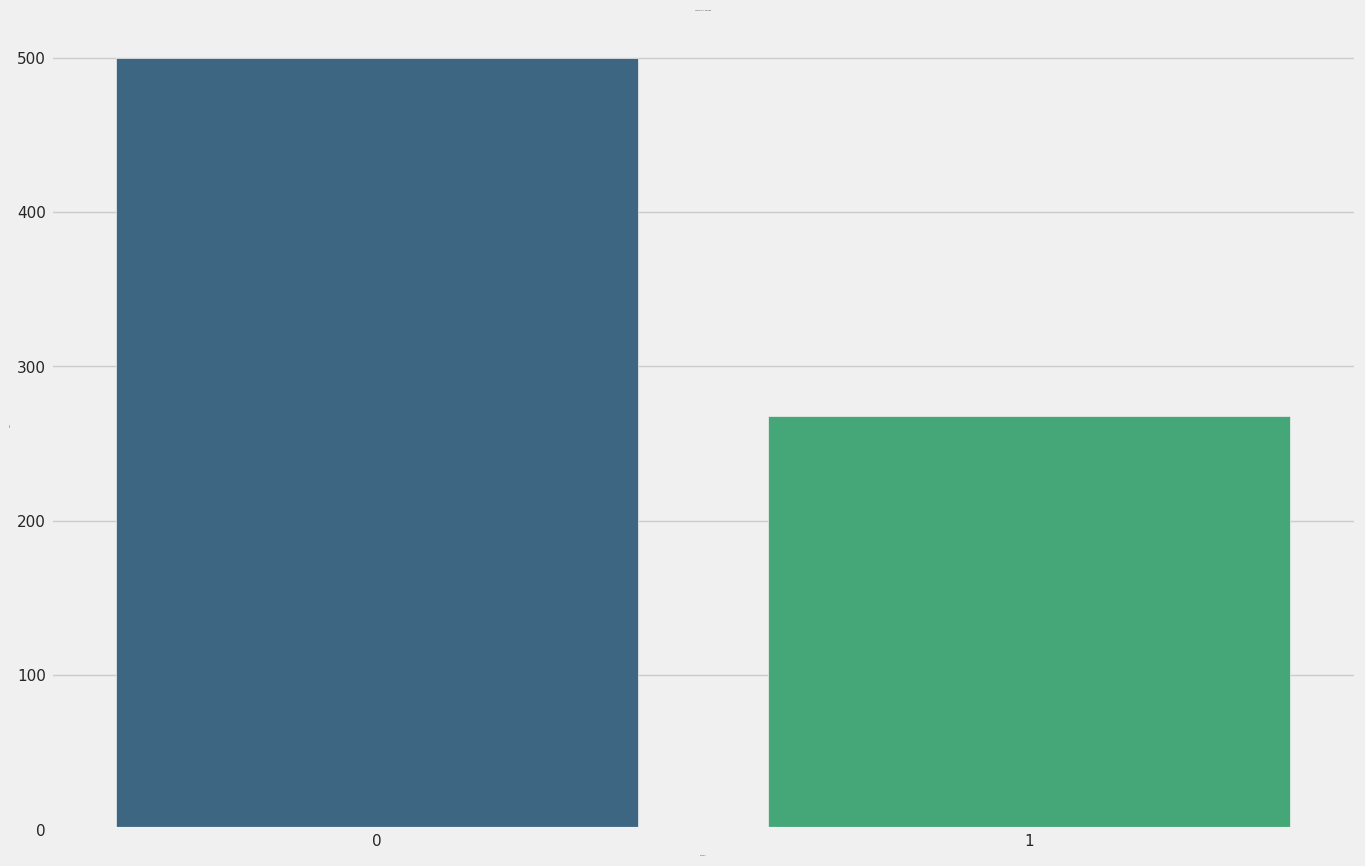

In [21]:
for column in df1.columns:
    plt.figure(figsize=(15, 10))
    sns.countplot(x=column, data=df1, palette="viridis")
    plt.title(f"Countplot for {column}", fontsize=1)
    plt.xlabel(column, fontsize=1)
    plt.ylabel("Count", fontsize=1)
    plt.show()

## Correlation heatmap

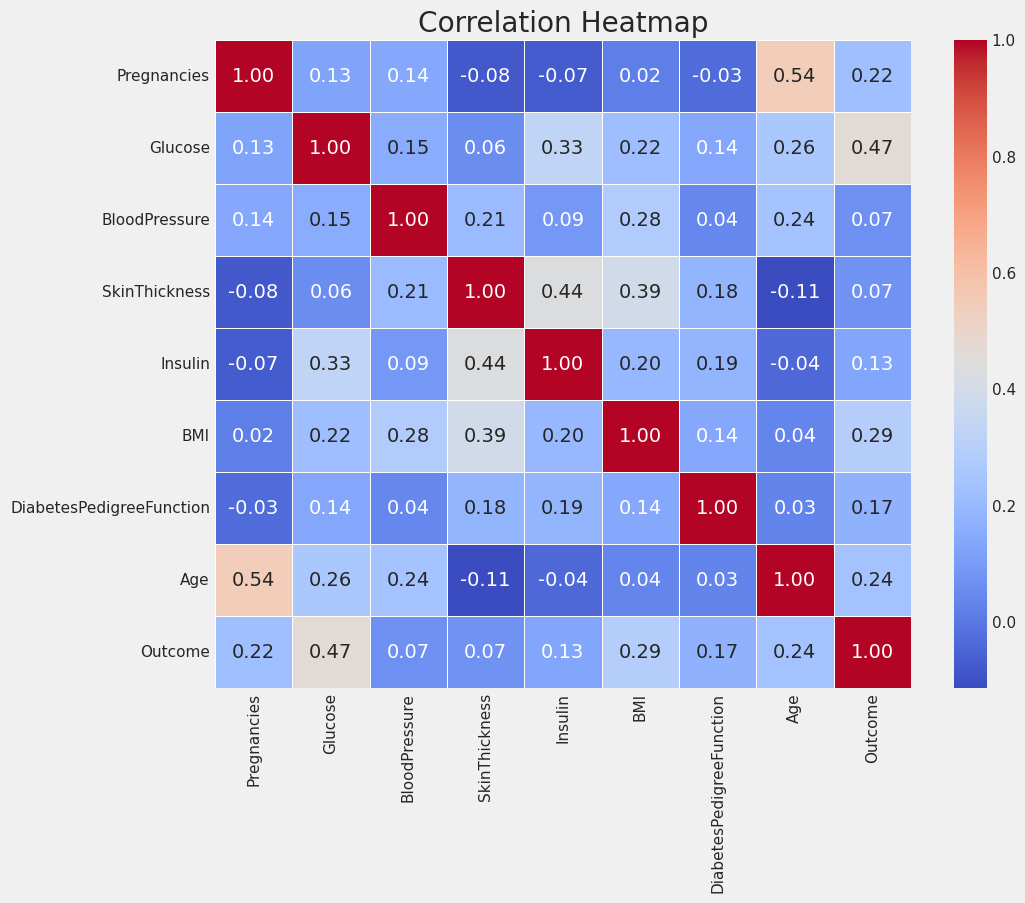

In [22]:
## Correlation heatmap
correlation_matrix = df1.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## StringIndexing


In [23]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in b]

In [24]:

## create a Pipeline
pipeline = Pipeline(stages=indexers)

## using the Pipeline to transform df
indexed_df = pipeline.fit(df).transform(df)


indexed_df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


## One-Hot Encoding

In [25]:
columns_to_drop = [f"{col}_index" for col in b]
indexed_df = indexed_df.drop(*columns_to_drop)

encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded") for col in b]
encoded_df = pipeline.fit(indexed_df).transform(indexed_df)

In [26]:
encoded_df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


## ML Models

In [28]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [32]:
categorical_columns = ["Outcome"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid='keep') for col in categorical_columns]

feature_columns = df.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='Outcome')

# Create the pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Split the data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(labelCol='Outcome', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data is: ", rmse)

Root Mean Squared Error (RMSE) on test data is:  0.4005670538269457
